# Search Tool Hotels: TwitterAPI Failure Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tweepy
from tqdm.notebook import tqdm

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)        

# TwitterAPI Authentication
auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'],
                                   twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],
                              twitter_credentials['access_token_secret'])
API = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=60*5)

# Fullnames

In [3]:
fn = pd.read_csv('Twitter-Search-Hotelname-Hotels.csv')
fn = fn.replace(np.nan, '')
fn.head()

,Hotel City,Hotelname,Twitter Handle,Website,Result 1,Result 2,Result 3,Result 4,Result 5,Result 6,...,Result 11,Result 12,Result 13,Result 14,Result 15,Result 16,Result 17,Result 18,Result 19,Result 20
0,Faliraki,Hotel Calypso Palace,,https://www.calypsopalace.gr/,1308314363086897152,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Platanes,Nefeli Hotel,,https://nefeli-hotel.gr/,364266196,388472346,747720708726349824,2440309615,1445935388,383129663,...,0,0,0,0,0,0,0,0,0,0
2,Kallithea,Hotel Kalithea Horizon Royal,,https://www.kalitheahorizon.gr/,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Archangelos,Porto Angeli Beach Resort Hotel,portoangeli,https://www.portoangeli.com/,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Faliraki,Hotel Calypso Beach,,http://www.calypsohotel.gr/,722657046122913793,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def get_ids(df):
    true_id = []
    for acc in tqdm(df):
        if acc != '':
            try:
                user = API.get_user(acc)
                true_id.append(user.id)
            except:
                print(acc)
                true_id.append(0)
        else:
            true_id.append(0)
    return true_id

In [5]:
cols = ['Twitter Handle']
for col in cols:
    fn[col] = get_ids(fn[col])

  0%|          | 0/100 [00:00<?, ?it/s]

## With a Twitter Account 

In [11]:
fn_acc = fn[fn['Twitter Handle'] != 0].copy() 

In [12]:
top1 = [False for i in range(len(fn_acc))]
top5 = [False for i in range(len(fn_acc))]
top10 = [False for i in range(len(fn_acc))]

for i, acc in enumerate(fn_acc['Twitter Handle']):
    for j,res in enumerate(fn_acc[[f'Result {k+1}' for k in range(10)]].iloc[i].unique()):
        if acc == res:
            if j < 1:
                top1[i] = True
            elif 0 < j < 6:
                top5[i] = True
            else:
                top10[j] = True

In [13]:
found = [a or b or c for a,b,c in zip(top1,top5,top10)]

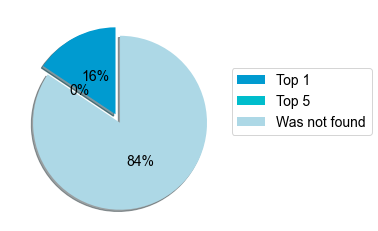

In [14]:
fig, ax = plt.subplots()
color_palette_list = ['#009BD0', '#00BDCC', '#ADD8E6']

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size']=14

x = [top1.count(True), top5.count(True), found.count(False)]
labels = ['Top 1', 'Top 5' ,'Was not found']
_=ax.pie(x, colors=color_palette_list,
         autopct='%1.0f%%', shadow=True, startangle=90, pctdistance=0.5,labeldistance=1.3, explode=(0.01,0.01,0.1))
ax.legend(frameon=True, bbox_to_anchor=(1,0.75), labels=labels)

## Without a Twitter Account 

In [15]:
target_names = ['Has an Account', 'Does not have a Account']

In [16]:
fn_noacc = fn[fn['Twitter Handle'] == 0].copy() 

In [17]:
correct = []
for i, acc in enumerate(fn_noacc['Twitter Handle']):
    if acc == fn_noacc['Result 1'].iloc[i]:
        correct.append(True)
    else:
        correct.append(False)         

In [18]:
correct.count(True), correct.count(False)

(50, 18)

## Final Results

In [19]:
fin_result = np.array([[found.count(True),correct.count(True)],
                      [found.count(False),correct.count(False)]])
fin_result

array([[ 5, 50],
       [27, 18]])

<AxesSubplot:>

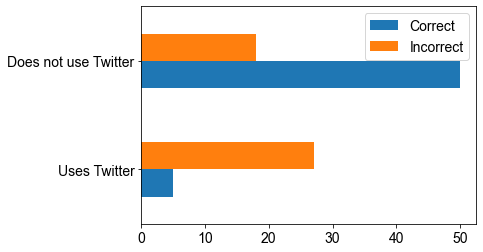

In [20]:
pd.DataFrame(fin_result, 
             columns=['Uses Twitter', 'Does not use Twitter'], 
             index=['Correct', 'Incorrect']).T.plot(kind='barh')